<a href="https://colab.research.google.com/github/Sudharsan0001/Customer_Lifetime_Value/blob/main/CLV_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Summary**

The primary objective of this project is to determine the lifetime value of our customers. The project workflow follows these steps:

*   Data cleaning to ensure accuracy and reliability.
*   Generating a comprehensive summary table capturing customer purchase behavior, including recency and frequency, utilizing the lifetimes package based on past transaction history.
*   Employing the BG/NBD and Gamma-Gamma models to calculate Customer Lifetime Value (CLV).









In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving online_retail.csv to online_retail.csv


In [ ]:
import io
customer_df = pd.read_csv(io.BytesIO(uploaded['online_retail.csv']))

In [ ]:
customer_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


The datatype of Invoice date feature is Object so we need to change that.

In [ ]:
customer_df['InvoiceDate'] = pd.to_datetime(customer_df['InvoiceDate'])

In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [ ]:
customer_df = customer_df.drop(['StockCode','Description','Country'],axis=1)

We have dropped the columns which are not useful for our analysis.

In [ ]:
customer_df['Total_Sales'] = customer_df['Price'].multiply(customer_df['Quantity'])

In [ ]:
customer_df.head()

,Invoice,Quantity,InvoiceDate,Price,Customer ID,Total_Sales
0,489434,12,2009-12-01 07:45:00,6.95,13085.0,83.4
1,489434,12,2009-12-01 07:45:00,6.75,13085.0,81.0
2,489434,12,2009-12-01 07:45:00,6.75,13085.0,81.0
3,489434,48,2009-12-01 07:45:00,2.10,13085.0,100.8
4,489434,24,2009-12-01 07:45:00,1.25,13085.0,30.0


In [ ]:
customer_df.isnull().sum()

Invoice             0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Total_Sales         0
dtype: int64

In [ ]:
customer_df = customer_df[pd.notnull(customer_df['Customer ID'])]

The aim of this project is to find the lifetime value for each customer who are identified with their customer Id. So if there is no customer Id in a row we can't identify which customer made that tansaction. So we have removed those rows.

In [ ]:
customer_df.isnull().sum()

Invoice        0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Total_Sales    0
dtype: int64

In [ ]:
customer_df.shape

(824364, 6)

In [ ]:
customer_df['Customer ID'] = customer_df['Customer ID'].astype(str)

In [ ]:
customer_df.describe()

,Quantity,Price,Total_Sales
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,20.195317
std,188.976099,70.241388,308.685001
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,4.250000
50%,5.000000,1.950000,11.250000
75%,12.000000,3.750000,19.500000
max,80995.000000,38970.000000,168469.600000


Quantity has negative values which would indicate that items were returned. Due to negative values in quantity, we have negative values in Total sales as well. For the purpose of our analysis, we only consider those transactions where total sales is > 0.

In [ ]:
customer_df = customer_df[customer_df['Total_Sales'] > 0]

In [ ]:
customer_df = customer_df.rename(columns={'Customer ID':'Customer_ID'})
customer_df['Customer_ID'] = customer_df['Customer_ID'].astype(str)

In [ ]:
customer_df.describe()

,Quantity,Price,Total_Sales
count,805549.000000,805549.000000,805549.000000
mean,13.290522,3.206561,22.026505
std,143.634088,29.199173,224.041928
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,5.000000,1.950000,11.850000
75%,12.000000,3.750000,19.500000
max,80995.000000,10953.500000,168469.600000


We are going to use BG/NBD and Gamma-Gamma model to calculate CLV. Both are probabilistic models (and not distance based models) so we don't have to scale the features.

In [ ]:
pip install Lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.4 MB/s eta 0:00:00


In [ ]:
import lifetimes

In [ ]:
summary_table = lifetimes.utils.summary_data_from_transaction_data(customer_df, 'Customer_ID', 'InvoiceDate', 'Total_Sales')
summary_table = summary_table.reset_index()
summary_table.head()

,Customer_ID,frequency,recency,T,monetary_value
0,12346.0,7.0,400.0,725.0,11066.637143
1,12347.0,7.0,402.0,404.0,717.398571
2,12348.0,4.0,363.0,438.0,449.310000
3,12349.0,3.0,571.0,589.0,1120.056667
4,12350.0,0.0,0.0,310.0,0.000000


Frequency - Indicates the number of repeat purchases a customer has made, If the customer has made only 1 purchase then the frequency is 0.

Recency - This is the difference (in terms of days) between th date of customer's first purchase and their latest purchase. If a customer has made only 1 purchase then the value is 0.

T - Indicates how long it has been (in terms of days) since he/she became a customer. Its the difference betwen the date of customer's first purchase and the last transaction date in the entire dataset.

<Axes: ylabel='Frequency'>

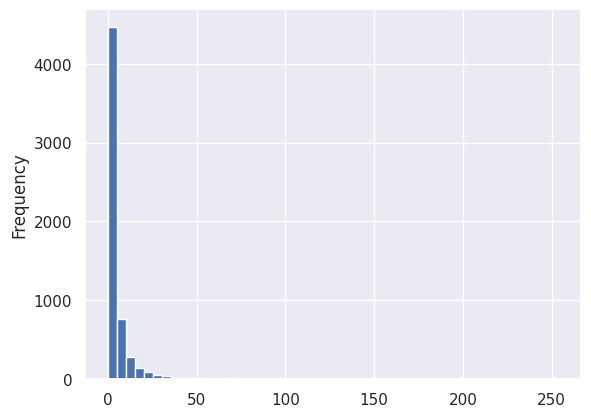

In [ ]:
summary_table['frequency'].plot(kind='hist', bins=50)

We have more than 4000 one time buyers in our data.

BG/NBD is a probabilistic model, It models the probability of future customer behavior based on past transaction history

In [ ]:
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_table['frequency'], summary_table['recency'], summary_table['T'])

<lifetimes.BetaGeoFitter: fitted with 5878 subjects, a: 0.11, alpha: 63.24, b: 2.42, r: 0.66>

In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.663527,0.015848,0.632466,0.694589
alpha,63.235539,1.936286,59.440418,67.030660
a,0.108643,0.015437,0.078387,0.138900
b,2.415697,0.524152,1.388358,3.443035


Parameters usually describe the charecteristics of the data. Here we have 4 parameters.

r - shape parameter of the Gamma distribution of the purchase process. This parameter is related to the expected number of future transactions a customer is expected to make given they are still active.

alpha - scale parameter of the Gamma distribution of the purchase process. another parameter in the purchase process. It's associated with the transaction rate for active customers.

a - Shape parameter of the Beta distribution of the dropout process. This parameter relates to the probability of a customer dropping out (becoming inactive) after each transaction. it's associated with the Beta distribution, which models the probability of customers churning or becoming inactive after a transaction.

b - shape parameter of the Beta distribution of the dropout process. It is related to the likelihood of a customer churning after each transaction.
It's also associated with the Beta distribution, jointly characterizing the churning behavior of customers after transactions.

In [ ]:
summary_table['probability_alive'] = bgf.conditional_probability_alive(summary_table['frequency'], summary_table['recency'], summary_table['T'])
summary_table.sample(10)

,Customer_ID,frequency,recency,T,monetary_value,probability_alive
2179,14548.0,5.0,583.0,733.0,389.442000,0.947662
2966,15342.0,0.0,0.0,129.0,0.000000,1.000000
3959,16344.0,3.0,510.0,668.0,211.106667,0.943375
3024,15402.0,5.0,443.0,591.0,249.296000,0.932512
4811,17208.0,0.0,0.0,395.0,0.000000,1.000000
3973,16358.0,4.0,393.0,394.0,506.875000,0.980136
4982,17379.0,0.0,0.0,11.0,0.000000,1.000000
5371,17779.0,2.0,122.0,143.0,167.740000,0.959380
146,12493.0,1.0,32.0,197.0,201.240000,0.806814
4094,16479.0,0.0,0.0,10.0,0.000000,1.000000


*   conditional_probability_alive() gives the probability of a customer being alive or active at a certain point in time given their past transactional behavior.
*  One of the drawbacks of the regular BG/NBD model is for customers who made only one purchase (frequency of 0), it always gives probability_alive of 1. To overcome this we can use modified BG/NBD model.

In [ ]:
mbgf = lifetimes.ModifiedBetaGeoFitter(penalizer_coef=0.0001)
mbgf.fit(summary_table['frequency'], summary_table['recency'], summary_table['T'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 5878 subjects, a: 0.12, alpha: 67.95, b: 2.32, r: 0.74>

In [ ]:
mbgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.744187,0.022124,0.700824,0.787550
alpha,67.950048,2.155917,63.724450,72.175646
a,0.121697,0.013166,0.095892,0.147503
b,2.318345,0.399931,1.534481,3.102210


In [ ]:
summary_table['modified_probability_alive'] = mbgf.conditional_probability_alive(summary_table['frequency'], summary_table['recency'], summary_table['T'])
summary_table.sample(20)

,Customer_ID,frequency,recency,T,monetary_value,probability_alive,modified_probability_alive
679,13028.0,1.0,23.0,45.0,305.380000,0.938409,0.949205
3994,16379.0,3.0,74.0,78.0,559.506667,0.973393,0.975237
1824,14191.0,14.0,727.0,728.0,342.982857,0.992872,0.992460
4053,16438.0,4.0,77.0,82.0,148.487500,0.976924,0.977877
1266,13627.0,6.0,581.0,640.0,323.583333,0.974404,0.974365
2017,14386.0,0.0,0.0,296.0,0.000000,1.000000,0.845292
4347,16737.0,1.0,524.0,577.0,417.600000,0.950637,0.959149
1486,13850.0,0.0,0.0,129.0,0.000000,1.000000,0.896147
1878,14245.0,1.0,44.0,263.0,688.350000,0.777446,0.804575
1077,13436.0,0.0,0.0,1.0,0.000000,1.000000,0.949607


We no longer get "alive" probability of 1 for all the customers who made only 1 purchase (frequency 0).

<Axes: xlabel='recency', ylabel='modified_probability_alive'>

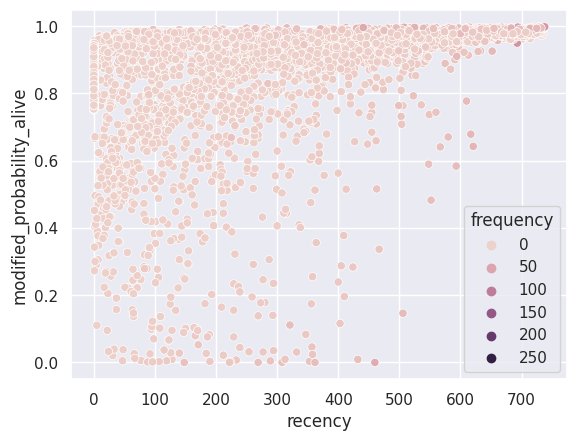

In [ ]:
sns.scatterplot(data=summary_table,x='recency',y='modified_probability_alive',hue='frequency')

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

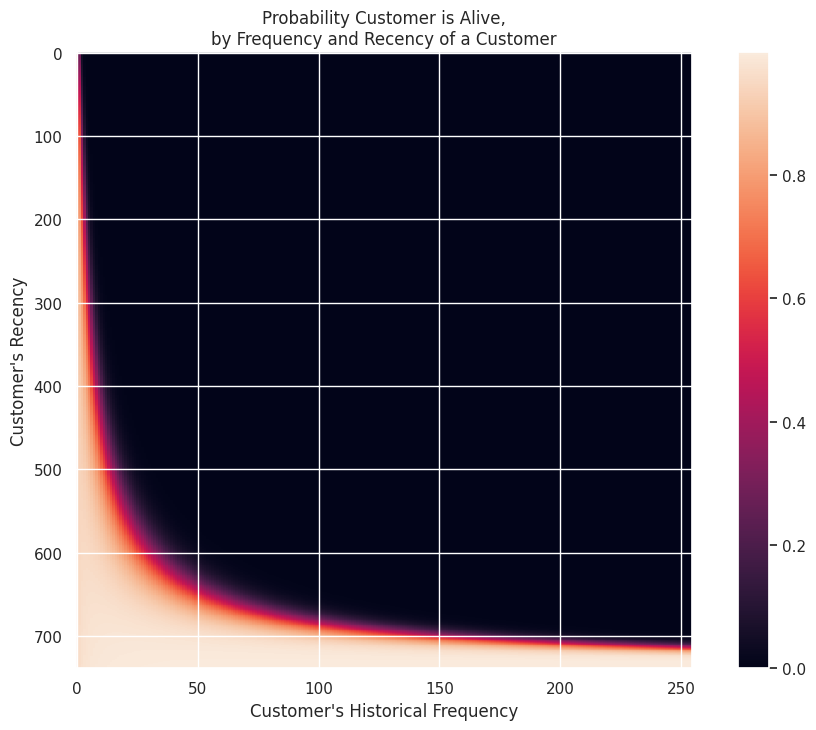

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(mbgf)

*   If a customer's frequency as well as recency are high then the probability of that customer being alive is high.
*   If a customer's frequency is low the probability of that customer being alive increases as the recency increases.
*   If a customer's frequency & recency are 0, i.e the customer had made only 1 purchase then the probability of that customer increases as the 'T' decreases. Since T is the difference b/w last transaction date in our entire dataset and the purchase date, the more recent the purchase is, higher is the probability of that customer being alive.





In [ ]:
t = 30
summary_table['pred_num_txn'] = round(mbgf.conditional_expected_number_of_purchases_up_to_time(t, summary_table['frequency'], summary_table['recency'], summary_table['T']),2)
summary_table.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,index,Customer_ID,frequency,recency,T,monetary_value,probability_alive,modified_probability_alive,pred_num_txn
0,2538,14911.0,254.0,737.0,738.0,1162.358268,0.999416,0.999349,9.46
1,400,12748.0,201.0,735.0,735.0,280.490000,0.999464,0.999402,7.52
2,2935,15311.0,195.0,738.0,738.0,594.605846,0.999447,0.999384,7.27
3,5433,17841.0,192.0,736.0,737.0,366.423490,0.999286,0.999205,7.16
4,2237,14606.0,180.0,735.0,736.0,170.255889,0.999250,0.999165,6.72
5,739,13089.0,131.0,735.0,737.0,888.318779,0.998861,0.998735,4.89
6,2158,14527.0,120.0,735.0,737.0,223.904250,0.998791,0.998658,4.48
7,1789,14156.0,120.0,729.0,738.0,2607.329750,0.996515,0.996154,4.47
8,622,12971.0,98.0,721.0,724.0,162.360612,0.998410,0.998238,3.73
9,1434,13798.0,98.0,730.0,731.0,768.906837,0.998764,0.998629,3.69


We have predicted the expected number of future transactions, we now have to predict the future monetary value of each transactions. To do this we us the gamma gamma model.

The key assumptions of the gamma gamma model are:
*   The monetary value of a customer’s given transaction varies randomly around their average transaction value.
*   Average transaction value varies across customers but do not vary over time for any given customer.
*  The distribution of average transaction values across customers is independent of the transaction process.






The Gamma-Gamma model is specifically designed to model the variability in monetary values among customers who have made multiple purchases. It estimates the variability in transaction values around each customer's average transaction value. So we are going to consider only those customrs who have made repeat purchases.

In [ ]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
return_customers = summary_table[summary_table['frequency']>0]
ggf.fit(return_customers['frequency'],
       return_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 11.71, q: 0.88, v: 11.69>

In [ ]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.712359,0.225051,11.271260,12.153459
q,0.879010,0.016861,0.845962,0.912059
v,11.685922,0.230130,11.234867,12.136978


In [ ]:
summary_table = summary_table[summary_table['monetary_value'] >0]
summary_table['expected_avg_sales'] = ggf.conditional_expected_average_profit(summary_table['frequency'],
                                       summary_table['monetary_value'])

In [ ]:
summary_table.head()

,Customer_ID,frequency,recency,T,monetary_value,probability_alive,modified_probability_alive,pred_num_txn,expected_avg_sales
0,12346.0,7.0,400.0,725.0,11066.637143,0.568601,0.563143,0.16,11084.664503
1,12347.0,7.0,402.0,404.0,717.398571,0.986835,0.986683,0.48,720.130705
2,12348.0,4.0,363.0,438.0,449.310000,0.959031,0.960399,0.27,453.402403
3,12349.0,3.0,571.0,589.0,1120.056667,0.973463,0.975238,0.17,1127.835522
6,12352.0,8.0,356.0,392.0,338.261250,0.976985,0.976511,0.56,340.161227


In [ ]:
summary_table['predicted_clv'] =      ggf.customer_lifetime_value(mbgf,
                                                               summary_table['frequency'],
                                                               summary_table['recency'],
                                                               summary_table['T'],
                                                               summary_table['monetary_value'],
                                                               time=1,
                                                               freq='D',
                                                               discount_rate=0.01)

where t=1 means 1 month, freq='D' indicates that our data is in daily level. discount rate is based on the concept of Discounted Cash flow where we discount the future monetary value by a discount rate to get the present value of that cash flow.

In [ ]:
summary_table.head()

,Customer_ID,frequency,recency,T,monetary_value,probability_alive,modified_probability_alive,pred_num_txn,expected_avg_sales,predicted_clv
0,12346.0,7.0,400.0,725.0,11066.637143,0.568601,0.563143,0.16,11084.664503,1807.353681
1,12347.0,7.0,402.0,404.0,717.398571,0.986835,0.986683,0.48,720.130705,345.213082
2,12348.0,4.0,363.0,438.0,449.310000,0.959031,0.960399,0.27,453.402403,120.948086
3,12349.0,3.0,571.0,589.0,1120.056667,0.973463,0.975238,0.17,1127.835522,185.824496
6,12352.0,8.0,356.0,392.0,338.261250,0.976985,0.976511,0.56,340.161227,186.952071


We have calculated CLV based on the sales value and not the actual profilt. In order to get the net profilt for each customer we can multiply the predicted CLV with a profit margin.

In [ ]:
profit_margin=0.03
summary_table['CLV'] = summary_table['predicted_clv'] * profit_margin
summary_table.head()

,Customer_ID,frequency,recency,T,monetary_value,probability_alive,modified_probability_alive,pred_num_txn,expected_avg_sales,predicted_clv,CLV
0,12346.0,7.0,400.0,725.0,11066.637143,0.568601,0.563143,0.16,11084.664503,1807.353681,54.220610
1,12347.0,7.0,402.0,404.0,717.398571,0.986835,0.986683,0.48,720.130705,345.213082,10.356392
2,12348.0,4.0,363.0,438.0,449.310000,0.959031,0.960399,0.27,453.402403,120.948086,3.628443
3,12349.0,3.0,571.0,589.0,1120.056667,0.973463,0.975238,0.17,1127.835522,185.824496,5.574735
6,12352.0,8.0,356.0,392.0,338.261250,0.976985,0.976511,0.56,340.161227,186.952071,5.608562


Thus we can identify high-value customers for targeted marketing efforts.